# PyTorchでAutoEncoderを実装する
本資料は、以下の資料に日本語のコメントを追加したものです。  
**DS-GA 1008 · SPRING 2020 · NYU CENTER FOR DATA SCIENCE**  
URL: https://atcold.github.io/pytorch-Deep-Learning/  
URL: https://atcold.github.io/pytorch-Deep-Learning/ja/ (日本語)  
**pytorch-Deep-Learning**  
URL: https://github.com/Atcold/pytorch-Deep-Learning  
**11-VAE.ipynb**  
URL: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/11-VAE.ipynb

# Google ColaboratoryにおけるGPUランタイムの設定
1. 接続をクリックする。  
2. 接続できるとRAMとディスクの容量が表示される。  
3. ランタイムから「ランタイムのタイプの変更」。GPUを選択して保存する。
4. コマンド nvidia-smi を使用してGPUのステータスを確認する。

In [1]:
!nvidia-smi

Wed Jun 29 05:36:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# PyTorchのバージョンの確認

In [2]:
# pytorchを仮にインポートしてバージョンを確認する
!python -c 'import torch; print(torch.__version__) '

1.11.0+cu113


# モジュールのインポート
ここではいくつかのモジュールをインポートします。モジュール(module)とは、クラスや関数を定義したファイルのことです。これは以下のいずれかの記述により実現される。

1.   import構文
2.   from A import B 構文
3.   from A import B as C 構文 

In [3]:
# PyTorchのインポート
import torch

# 処理デバイス名を設定する。
# GPUを使うなら cuda:0 ←複数台のGPUがある場合、番号を指定する。
# CPUを使うなら cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 使用するモジュール
**[torchvision](https://github.com/pytorch/vision)**  
"The torchvision package consists of popular datasets, 
model architectures, and common image transformations for computer vision."  
実験用のデータセットが含まれるほか、以下のような機能を有する。  
Transform, Classification, Semantic Segmentation, Object Detection,
Video Classification, Opticalflow, ...

**[nn](https://github.com/torch/nn)**  
"This package provides an easy and modular way to build and train simple
or complex neural networks using Torch"  
以下のような機能を有する。  
2,3-dimensional convolution, max pooling, linear, ReLU, softmax, ...。

**[DataLoader](https://pytorch.org/docs/stable/data.html)**  
DataLoaderを使うことでミニバッチ処理が簡単に実行できる。

**[Transforms](https://pytorch.org/vision/0.9/transforms.html)**  
NNを実行する前の前処理における変形などの機能を含む。

**[MNIST](https://pytorch.org/vision/stable/datasets.html)**  
手書き文字データベースMNISTを読み込む。

**[matplotlib](https://github.com/matplotlib/matplotlib)**  
ここでは2次元画像の描画に使用する。

In [4]:
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

# 関数定義：画像をタイル状に表示
**Funcion Name**: display_images()  
**Argument**:  
in_ : 入力画像配列(例えばVAEの入力画像用)  
out : 入力画像配列(例えばVAEの出力画像用)  
n : 表示する画像は 4*n。与えられない場合は 1 となる。  

In [5]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

# 乱数シードを設定する
**[manual_seed](https://pytorch.org/docs/stable/generated/torch.manual_seed.html)**  
乱数生成のための初期値を設定する。  
**[cuda.manual_seed](https://pytorch.org/docs/stable/generated/torch.cuda.manual_seed.html)**  
GPUにおける乱数生成のための初期値を設定する。ただし、複数のGPUを用いる場合は *manual_seed_all()* を用いること。  

In [6]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

# 学習・テストデータローダの生成
MNIST画像データベースを用いて学習用データとテスト用データを生成します。DataLoaderの *shuffle* は True に設定し、ランダムな画像の取り出しとします。

In [7]:
# Define data loading step

batch_size = 256

kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# モデルアーキテクチャの定義
### エンコーダ
２層の全結合層からなる。1層目の入力は ```28*28=784``` となり、出力は ```d*d``` である。2層目の入力は ```d*d``` となり、出力は ```2*d``` となる。この出力の前半の d は平均値、後半の d は分散である。これを ```forward()``` において受け取り、```view(-1, 2, d)```を用いて平均値と分散のデータ配列を分割する。
### デコーダ
２層の全結合層からなる。1層目の入力は ```2*d``` となり、出力は ```d*d``` である。2層目の入力は ```d*d``` となり、出力は ```28*28=784``` である。

**[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)**  
モジュールインスタンスを順次処理するためのコンテナ  
**[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)**  
全結合層    
*in_features* – サンプル単位の入力サイズ。ここでは28x28の画像が入力されるので 28x28=784 となる。  
*out_features* - サンプル単位の出力サイズ。ここでは変数 *d* によって指定される。  
**[ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)**  
活性化関数（Rectified Linear Unit）  
**[Sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)**  
活性化関数。出力値の範囲は[0.0, 1.0]となる。  

In [8]:
# Defining the model

d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

# 学習率および最適化手法の設定
**[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)** Adaptive Moment Estimation   

In [9]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

# 損失関数の定義
再構成損失（Binary Cross Entropy）とKL情報量を用いたペナルティ項からなる損失関数を定義する。  
[binary_cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html)  
**input** 入力データ。  
**target** 入力データと同じシェイプを持つデータ。値の範囲は[0.0, 1.0]。  
**reduction** 初期値は ```mean```。```sum``` を設定すると合計値が出力される。  

In [10]:
# Reconstruction + β * KL divergence losses summed over all elements and batch

def loss_function(x_hat, x, mu, logvar, β=1):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + β * KLD

# 学習とテスト
エポック単位にテスト結果を確認するため、繰り返しの中で学習・テストを対にして実行している。なお、初回に学習なしの状態での出力を確認するため、学習には ```if epoch > 0``` の条件が設定されている。

====> Test set loss: 544.4362
====> Epoch: 1 Average loss: 190.6598
====> Test set loss: 136.9074
====> Epoch: 2 Average loss: 133.0883
====> Test set loss: 115.7992
====> Epoch: 3 Average loss: 121.2602
====> Test set loss: 108.6809
====> Epoch: 4 Average loss: 116.1506
====> Test set loss: 105.2960
====> Epoch: 5 Average loss: 113.2174
====> Test set loss: 103.3297
====> Epoch: 6 Average loss: 111.4434
====> Test set loss: 101.3777
====> Epoch: 7 Average loss: 110.1311
====> Test set loss: 100.9601
====> Epoch: 8 Average loss: 109.2610
====> Test set loss: 99.0607
====> Epoch: 9 Average loss: 108.4726
====> Test set loss: 98.3653
====> Epoch: 10 Average loss: 107.8615
====> Test set loss: 98.7467


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


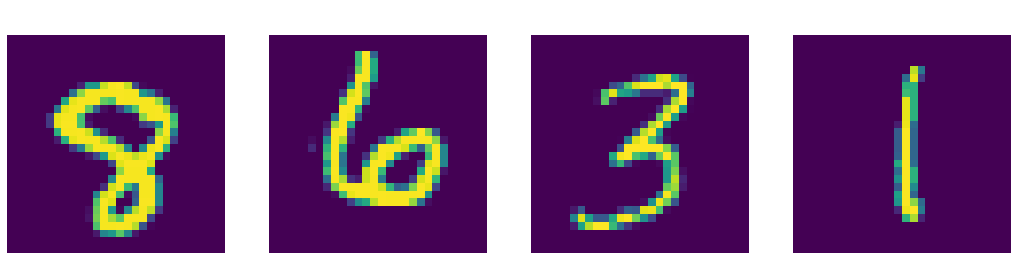

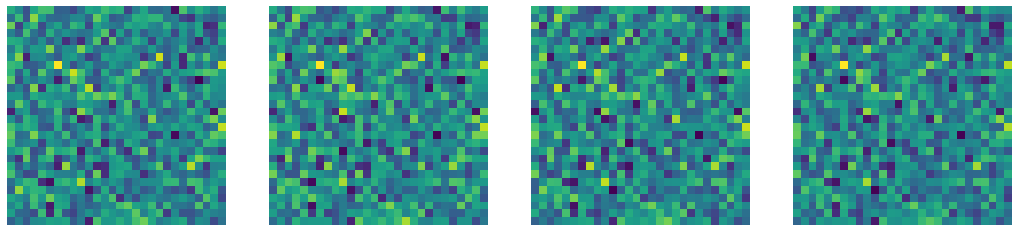

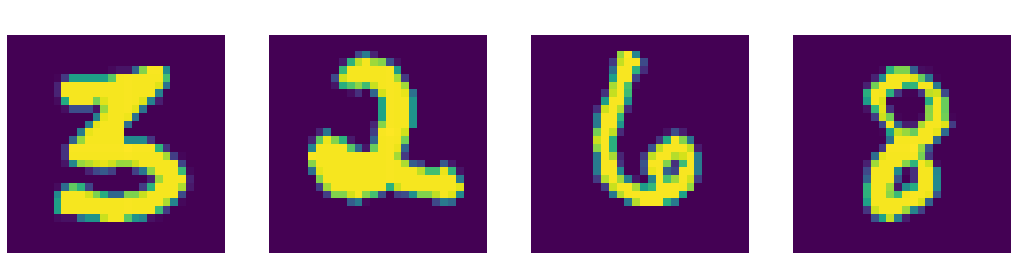

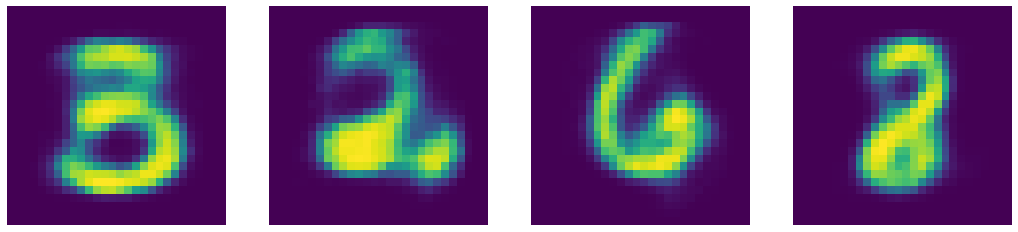

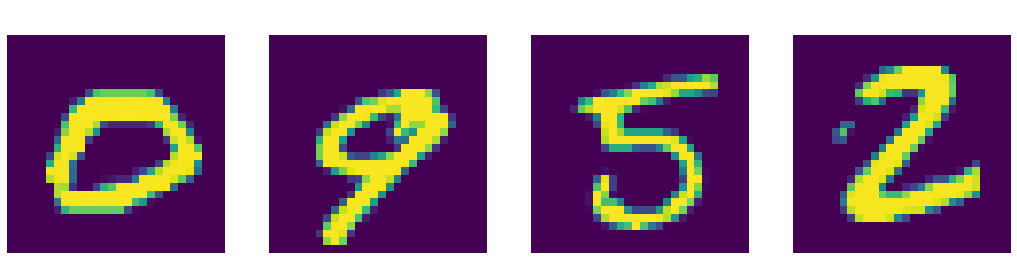

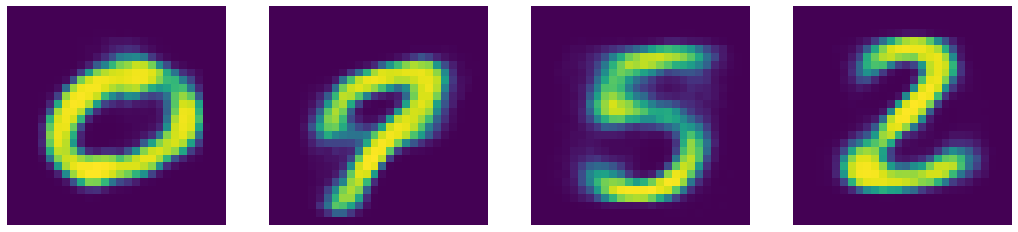

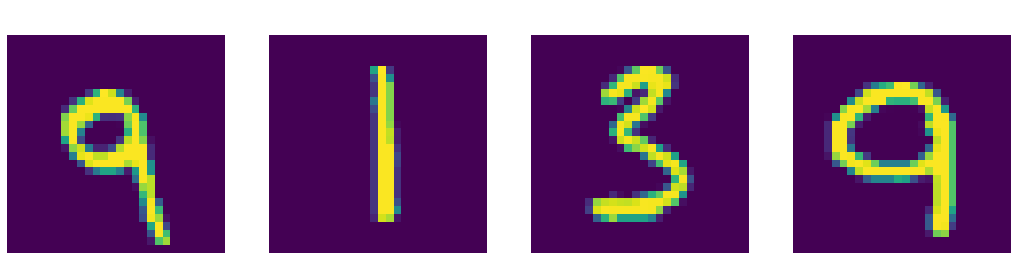

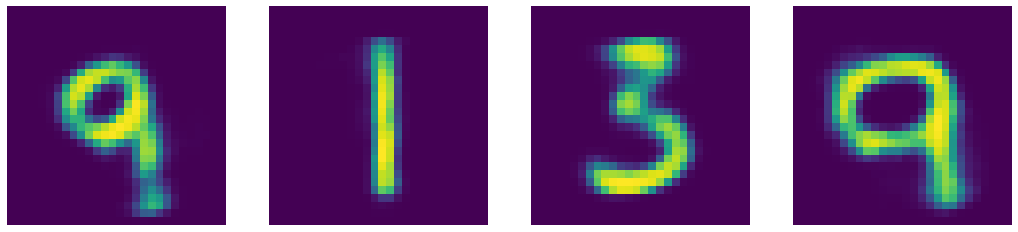

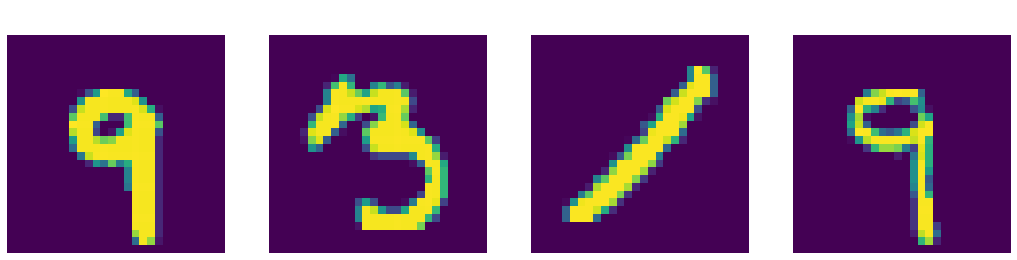

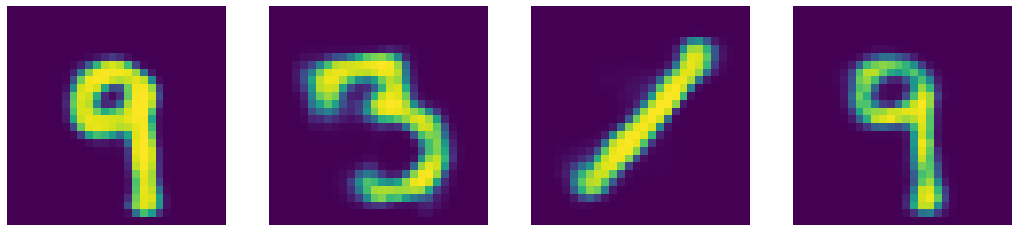

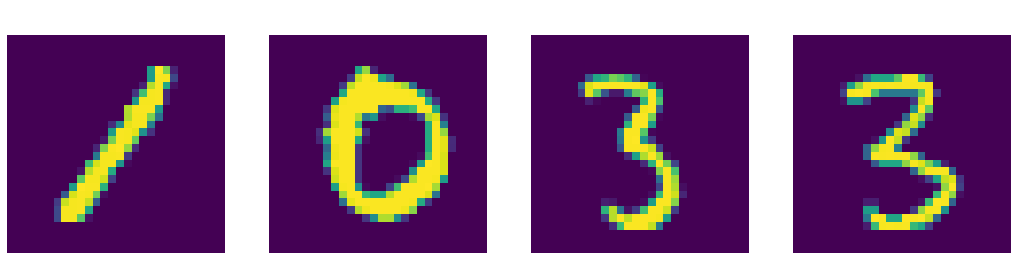

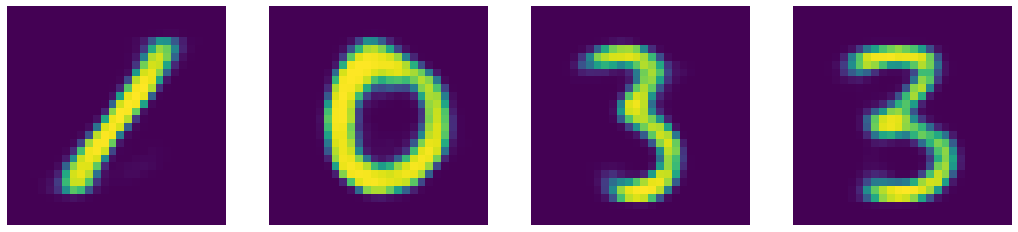

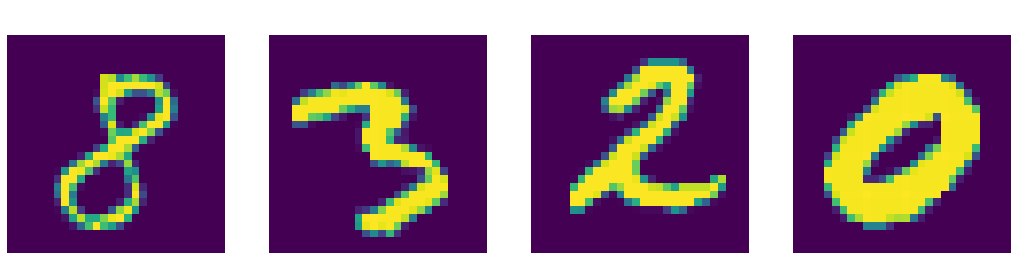

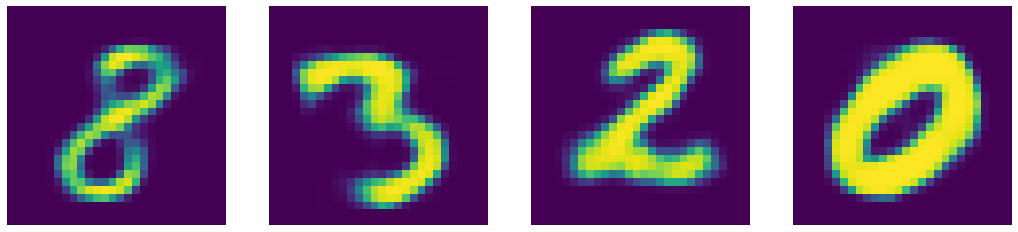

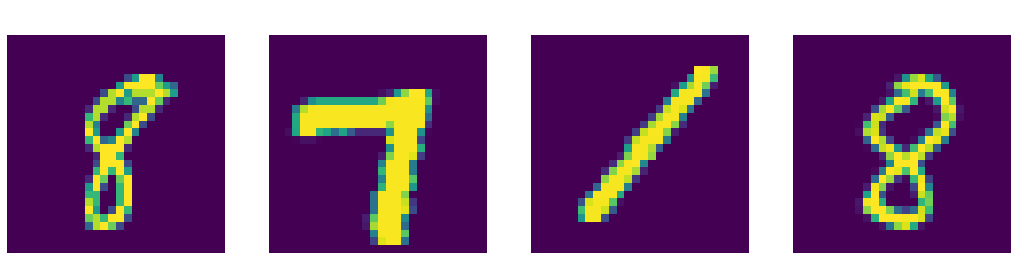

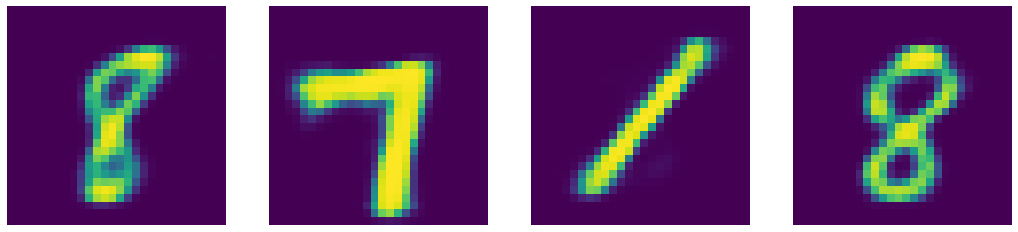

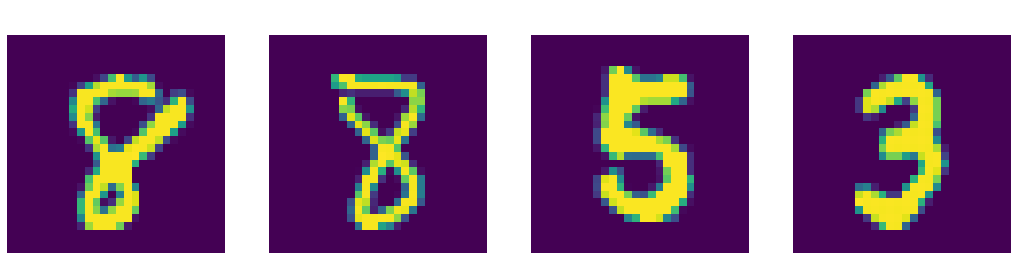

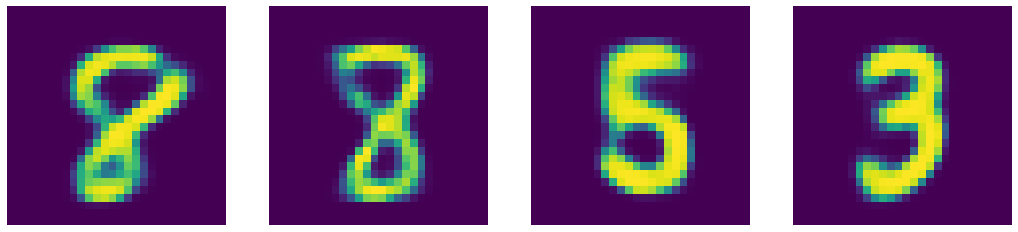

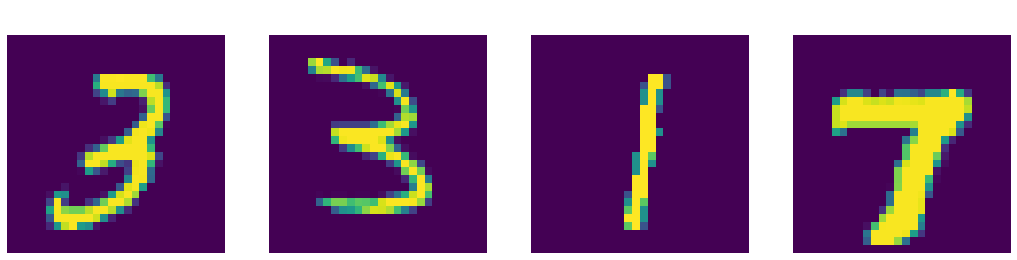

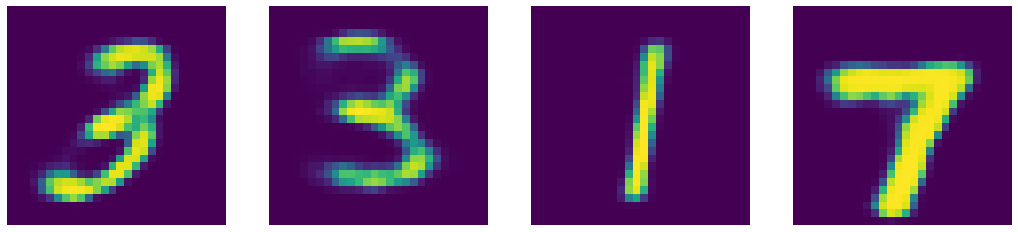

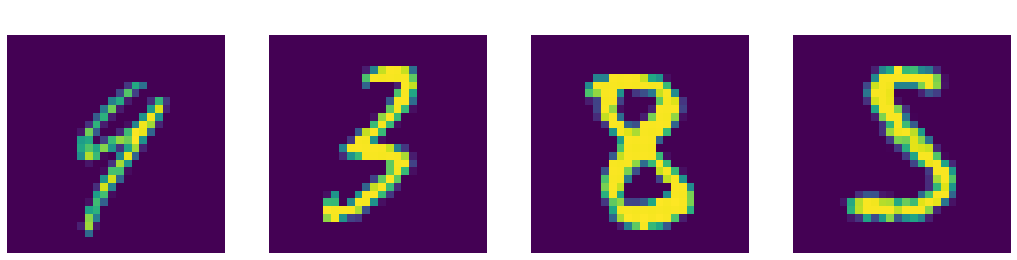

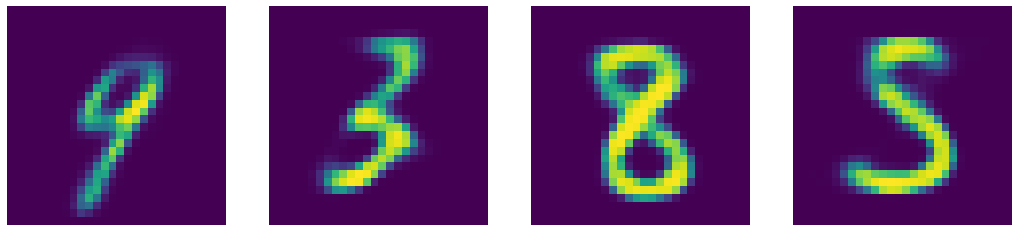

In [11]:
# Training and testing the VAE

epochs = 10
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

# サンプリングと画像生成
モデルを学習後に、正規分布からランダムなzをサンプリングしてデコーダに入力します。ここでは ```N=16, d=20``` であるから、16個の乱数がデコーダに入力されて16個の画像が生成される。  
**[randn](https://pytorch.org/docs/stable/generated/torch.randn.html)**  
平均 0 と分散 1 の正規分布 (標準正規分布) から乱数で満たされたテンソルを取得します。

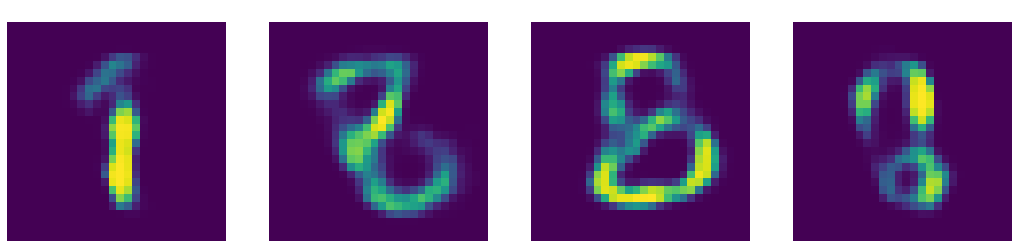

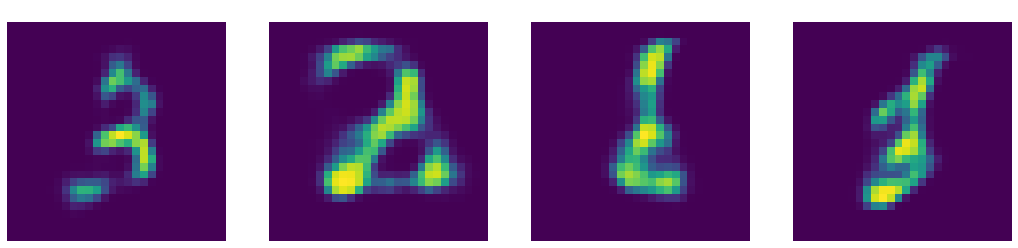

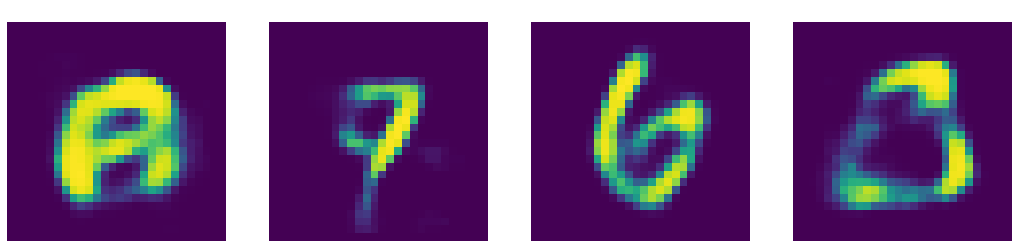

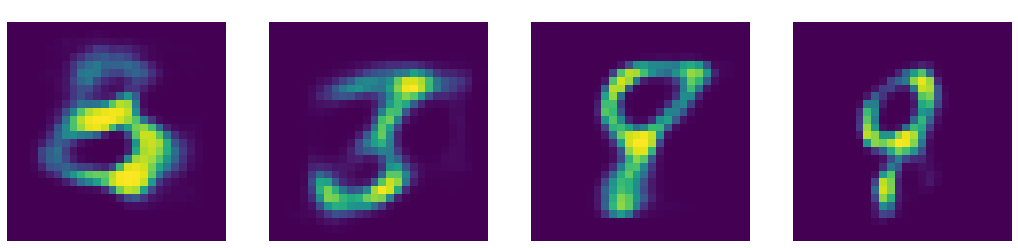

In [12]:
# Generating a few samples

N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

# 最後のテスト画像の表示
あらかじめ定義した関数```display_images()```を用いて4×4=16枚のテスト用画像を表示する。

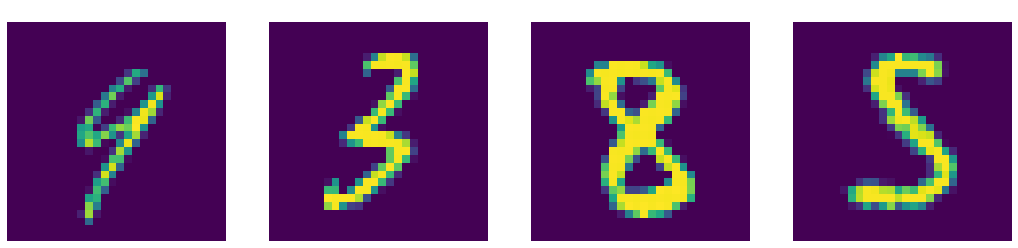

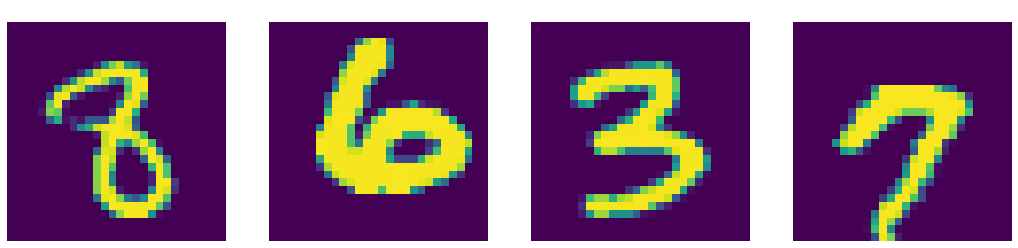

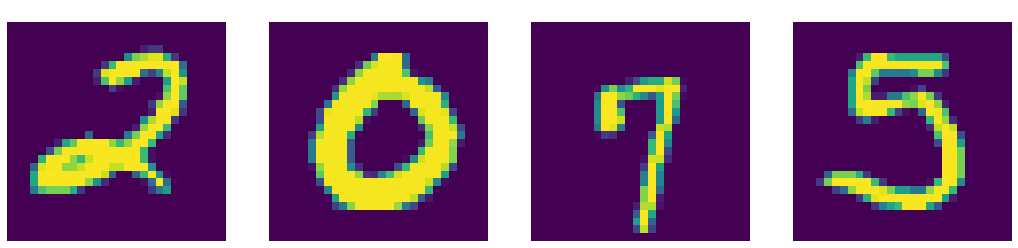

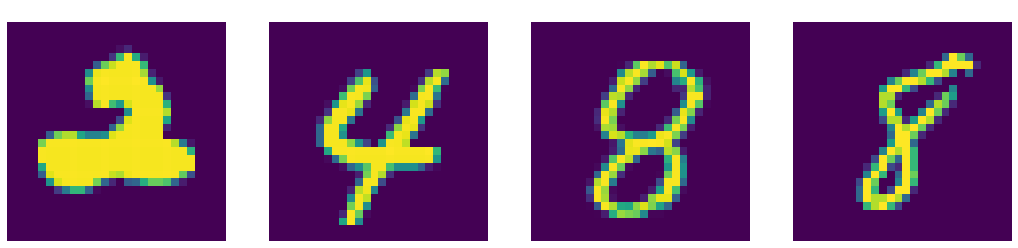

In [13]:
# Display last test batch

display_images(None, x, 4, count=True)

# 最後のテスト画像の一部を表示
１つ前のステップで表示した16枚の画像の中から、1番目と14番目のテスト用画像を取り出し、デコーダに入力した結果を```sample```に格納して表示する。ここで```mu[A]```または```mu[B]```を使用しているが、これは学習・テストの反復処理の最後のエポックにおける平均値が```mu```に保存されているため利用できる。

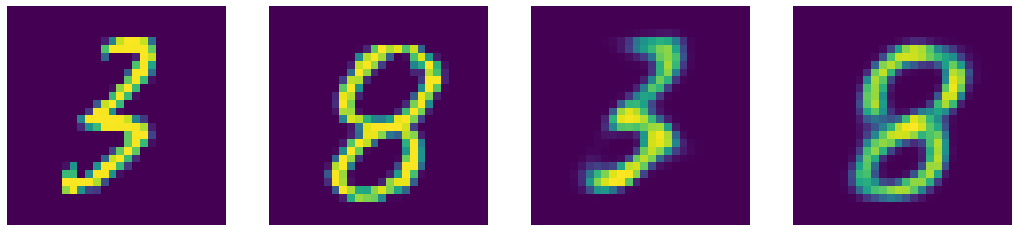

In [14]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed

A, B = 1, 14
sample = model.decoder(torch.stack((mu[A].data, mu[B].data), 0))
display_images(None, torch.stack(((
    x[A].data.view(-1),
    x[B].data.view(-1),
    sample.data[0],
    sample.data[1]
)), 0))

# 2枚の画像間の変形
上記２枚の画像間の平均値を徐々に近づけることで、潜在空間を可視化する。

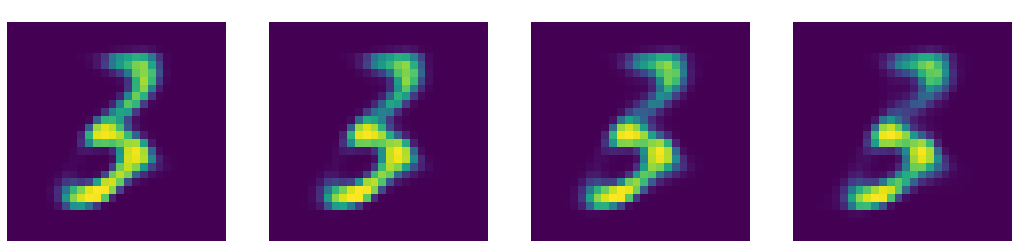

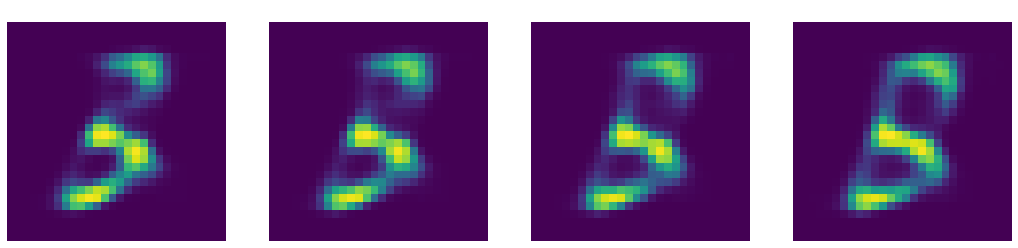

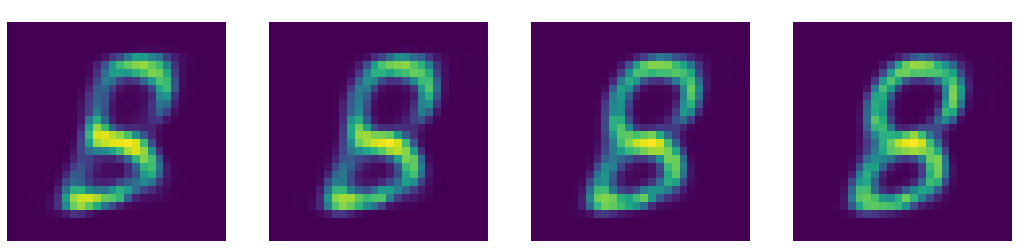

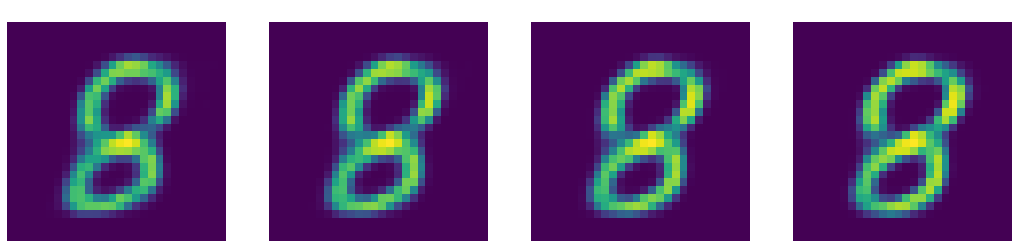

In [15]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = torch.Tensor(N, 20).to(device)
sample = torch.Tensor(N, 28, 28).to(device)
for i in range(N):
    code[i] = i / (N - 1) * mu[B].data + (1 - i / (N - 1) ) * mu[A].data
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample, N // 4, count=True)

# 学習状況の可視化のためのライブラリのインポート

In [17]:
import numpy as np
from sklearn.manifold import TSNE
# from res.plot_lib import set_default
# ↑コメントアウト

# 学習状況の可視化用キャンバスのパラメータ設定

In [19]:
# set_default(figsize=(15, 4))
# ↓変更
plt.rcParams['figure.figsize'] = [15.0, 4.0]

# 学習状況の可視化のためのデータ準備

In [20]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['μ'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1].detach().cpu()))
    Y.append(codes['y'][epoch][:N])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

# 学習回別の潜在空間の可視化
色は出力クラス（つまり数値の0から9のいずれか）である。

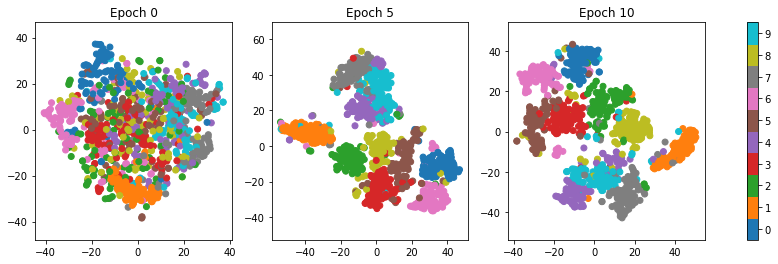

In [21]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)